In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font",family='YouYuan')
import seaborn as sns

#### 数据预处理

In [2]:
# 读取数据

total_data = pd.read_csv("totalData.csv", header=0, encoding='utf-8')
total_data = total_data.drop('序号', axis=1) #axis=1表示删除列，axis=0表示删除行
total_data['客运量（万人次）'] = total_data['客运量（万人次）'].astype(float)
total_data['进站量（万人次）'] = total_data['进站量（万人次）'].astype(float)
total_data['客运强度（万人次每公里日）'] = total_data['客运强度（万人次每公里日）'].astype(float)

total_data['时间'] = total_data['时间'].astype(str)
total_data['时间'] = pd.to_datetime(total_data['时间'],format='%Y%m')
total_data['时间'] = total_data['时间'].dt.to_period('M')
total_data['时间'] = total_data['时间'].dt.strftime('%Y-%m')


# 对一些分区的城市进行合并，比如嘉兴（海宁）和嘉兴
total_data['城市'] = total_data['城市'].replace(['嘉兴（海宁)', '嘉兴（海宁）', '海宁'], '嘉兴')
total_data['城市'] = total_data['城市'].replace(['苏州（昆山)', '昆山'], '苏州')
total_data['城市'] = total_data['城市'].replace(['镇江(句容)','句容'], '镇江')
total_data = total_data.groupby(['城市', '时间']).sum().reset_index() # 按照城市、时间双变量分组求和，这是为了解决<如果昆山有1条线路，苏州有10条线路，将昆山改成苏州后，会拉低平均铁路数目。实际上应该是11条>

total_data.head()



,城市,时间,运营线路条数,运营里程（公里）,客运量（万人次）,进站量（万人次）,客运强度（万人次每公里日）
0,三亚,2021-01,1,8.4,13.4,13.4,0.05
1,三亚,2021-02,1,8.4,13.0,13.0,0.06
2,三亚,2021-03,1,8.4,13.6,13.6,0.05
3,三亚,2021-04,1,8.4,10.5,10.5,0.04
4,三亚,2021-05,1,8.4,8.6,8.6,0.03


#### 城市平均cityAverage（dataframe）
cityAverage：dataframe：移除'时间'列, 对每个城市求平均

In [3]:
cityAverage = total_data.drop('时间',axis=1).groupby('城市').mean()
# 恢复第一列的列名’城市‘
cityAverage.reset_index(inplace=True)
cityAverage.head()

,城市,运营线路条数,运营里程（公里）,客运量（万人次）,进站量（万人次）,客运强度（万人次每公里日）
0,三亚,1.030303,8.654545,8.475758,8.439394,0.032727
1,上海,20.272727,830.333333,27123.657576,15058.296970,1.114848
2,东莞,1.030303,38.945455,338.521212,338.521212,0.294848
3,乌鲁木齐,1.030303,27.612121,244.696970,244.696970,0.301212
4,佛山,4.454545,81.000303,823.027273,690.542424,0.373030


#### 计算相关系数矩阵

c:\ProgramData\anaconda3\envs\dataScience\Lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
c:\ProgramData\anaconda3\envs\dataScience\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


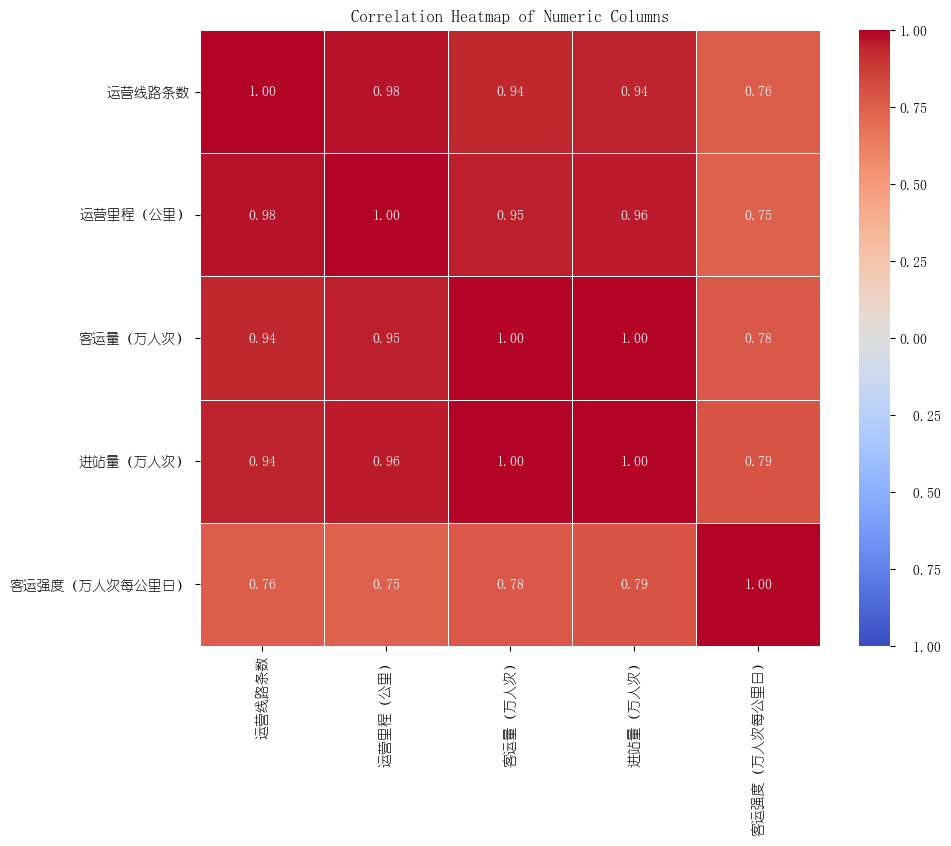

In [4]:
## 选择合适的特征进行聚类
# 提取数值型列，不包括索引列
numeric_columns = cityAverage.select_dtypes(include=['float64', 'int64']).columns

# 计算相关系数矩阵
correlation_matrix = cityAverage[numeric_columns].corr()

# 使用Seaborn绘制相关系数图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

#### 将cityAverage的所有特征进行聚类

In [5]:
allFeatures = cityAverage[['运营线路条数', '运营里程（公里）', '客运量（万人次）', '进站量（万人次）', '客运强度（万人次每公里日）']]

# 对数据进行标准化
scaler = StandardScaler()
allFeatures_scaled = scaler.fit_transform(allFeatures) 

kmeans = KMeans(n_clusters=4, random_state=0) # 建立kmeans模型实例
kmeans.fit(allFeatures_scaled) # 用fit方法训练kmeans实例
cityAverage['类别'] = kmeans.labels_

# 调整聚类标签顺序
cluster_means = cityAverage.groupby('类别')['客运强度（万人次每公里日）'].mean().reset_index()
cluster_means = cluster_means.sort_values('客运强度（万人次每公里日）', ascending=False)
label_mapping = {cluster_means.iloc[i]['类别']: label for i, label in enumerate(['A类城市', 'B类城市', 'C类城市', 'D类城市'])}
cityAverage['类别'] = cityAverage['类别'].map(label_mapping)

# Sort the dataframe based on '类别' and '客运强度（万人次每公里日）'
cityAverage = cityAverage.sort_values(by=['类别','客运强度（万人次每公里日）'], ascending=[True,False])

cityAverage.head(3)

# 输出聚类结果, 浮点型保留两位小数
cityAverage.to_csv('../聚类结果.csv', index=False, float_format='%.2f', encoding='utf-8-sig')

c:\ProgramData\anaconda3\envs\dataScience\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\envs\dataScience\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


#### 客运强度 v.s. 城市

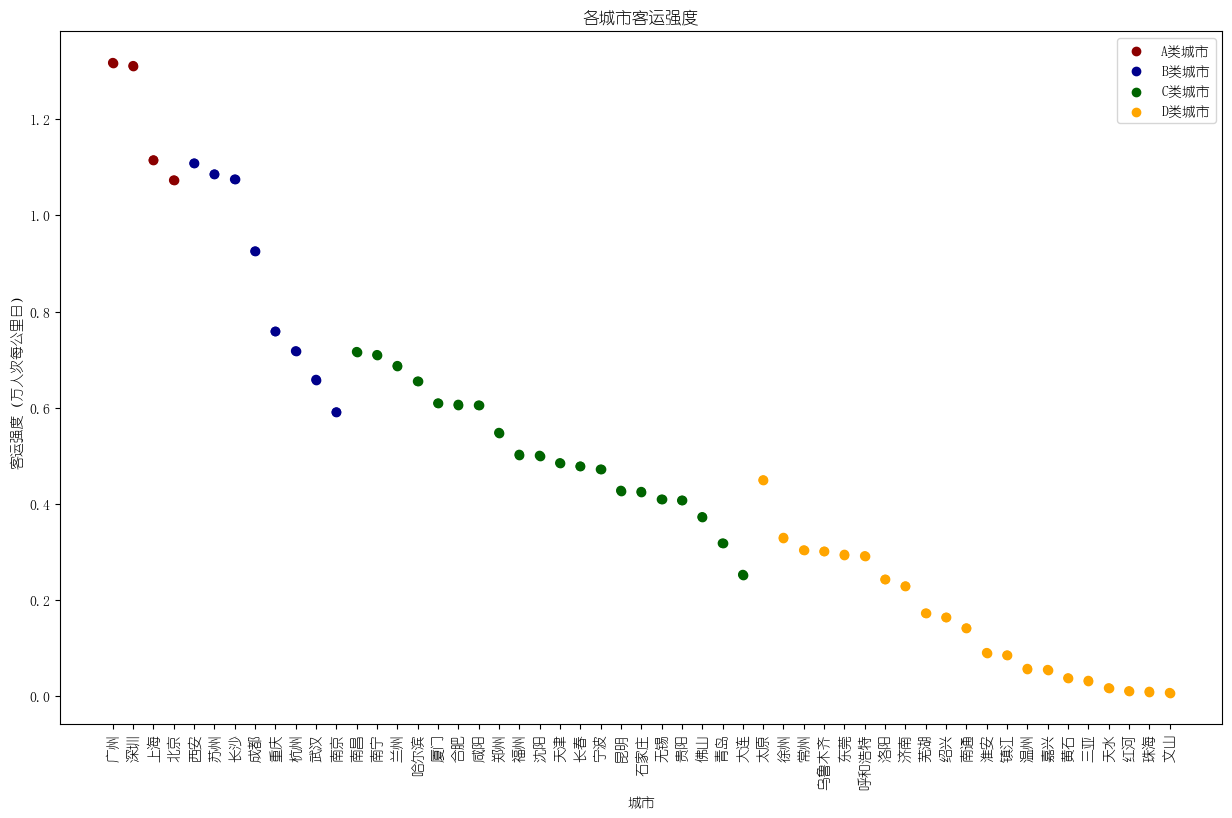

In [6]:
#绘制客运强度-城市散点图，纵轴是客运强度，横轴是城市（string），不同类别用不同颜色表示

color_map = {'A类城市':'darkred', 'B类城市':'darkblue', 'C类城市':'darkgreen', 'D类城市':'orange'}
colors = cityAverage['类别'].map(color_map)


plt.figure(figsize=(15, 9))

for category, color in color_map.items():
    plt.scatter(cityAverage[cityAverage['类别'] == category]['城市'], 
                cityAverage[cityAverage['类别'] == category]['客运强度（万人次每公里日）'], 
                c=color, 
                label=category)

plt.scatter(cityAverage['城市'], cityAverage['客运强度（万人次每公里日）'], c=colors)
plt.xlabel('城市')
plt.xticks(rotation=90)
plt.ylabel('客运强度（万人次每公里日）')
plt.title('各城市客运强度')
plt.legend()

plt.show()



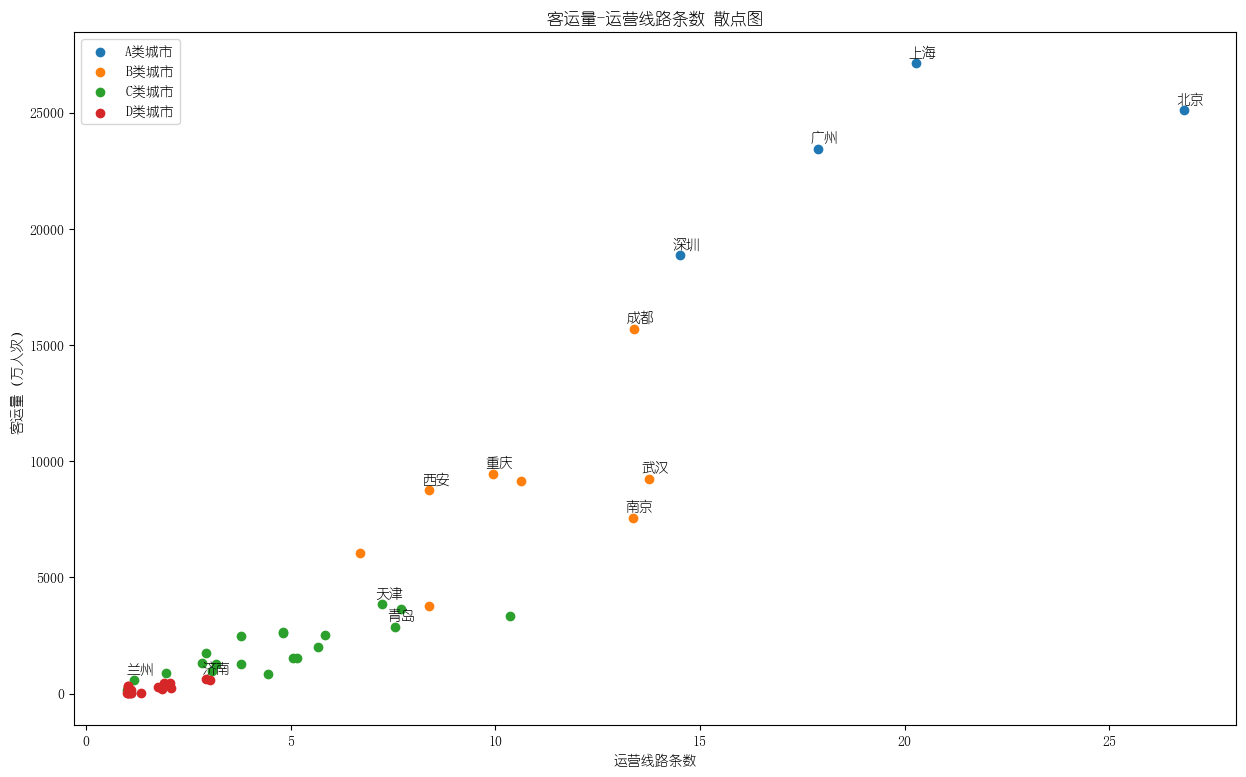

In [7]:
# 分类后客运量-运营线路散点图

plt.figure(figsize=(15,9))
plt.scatter(cityAverage['运营线路条数'][cityAverage['类别'] == 'A类城市'], cityAverage['客运量（万人次）'][cityAverage['类别'] == 'A类城市'], label='A类城市')
plt.scatter(cityAverage['运营线路条数'][cityAverage['类别'] == 'B类城市'], cityAverage['客运量（万人次）'][cityAverage['类别'] == 'B类城市'], label='B类城市')
plt.scatter(cityAverage['运营线路条数'][cityAverage['类别'] == 'C类城市'], cityAverage['客运量（万人次）'][cityAverage['类别'] == 'C类城市'], label='C类城市')
plt.scatter(cityAverage['运营线路条数'][cityAverage['类别'] == 'D类城市'], cityAverage['客运量（万人次）'][cityAverage['类别'] == 'D类城市'], label='D类城市')
cities_to_annotate = ['北京','上海', '南京', '济南', '西安', '天津', '广州', '深圳','成都','武汉','重庆','兰州','青岛']
for city in cities_to_annotate:
    x = cityAverage.loc[cityAverage['城市'] == city, '运营线路条数'].values[0]
    y = cityAverage.loc[cityAverage['城市'] == city, '客运量（万人次）'].values[0]
    plt.annotate(city, (x, y), textcoords="offset points", xytext=(5,5), ha='center')
plt.xlabel('运营线路条数')
plt.ylabel('客运量（万人次）')
plt.title('客运量-运营线路条数 散点图')
plt.legend()
plt.show()

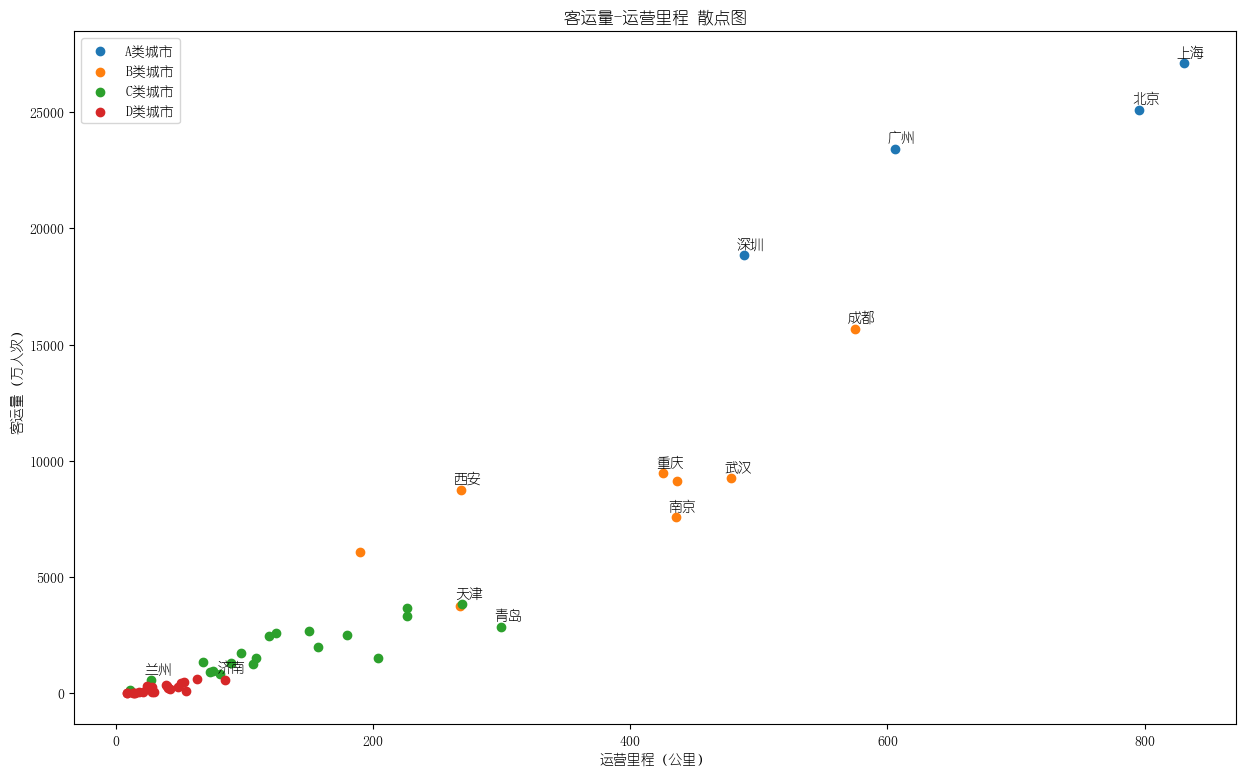

In [8]:
# 分类后客运量-客运里程散点图

plt.figure(figsize=(15,9))
plt.scatter(cityAverage['运营里程（公里）'][cityAverage['类别'] == 'A类城市'], cityAverage['客运量（万人次）'][cityAverage['类别'] == 'A类城市'], label='A类城市')
plt.scatter(cityAverage['运营里程（公里）'][cityAverage['类别'] == 'B类城市'], cityAverage['客运量（万人次）'][cityAverage['类别'] == 'B类城市'], label='B类城市')
plt.scatter(cityAverage['运营里程（公里）'][cityAverage['类别'] == 'C类城市'], cityAverage['客运量（万人次）'][cityAverage['类别'] == 'C类城市'], label='C类城市')
plt.scatter(cityAverage['运营里程（公里）'][cityAverage['类别'] == 'D类城市'], cityAverage['客运量（万人次）'][cityAverage['类别'] == 'D类城市'], label='D类城市')
cities_to_annotate = ['北京','上海', '南京', '济南', '西安', '天津', '广州', '深圳','成都','武汉','重庆','兰州','青岛']
for city in cities_to_annotate:
    x = cityAverage.loc[cityAverage['城市'] == city, '运营里程（公里）'].values[0]
    y = cityAverage.loc[cityAverage['城市'] == city, '客运量（万人次）'].values[0]
    plt.annotate(city, (x, y), textcoords="offset points", xytext=(5,5), ha='center')
plt.xlabel('运营里程（公里）')
plt.ylabel('客运量（万人次）')
plt.title('客运量-运营里程 散点图')
plt.legend()
plt.show()

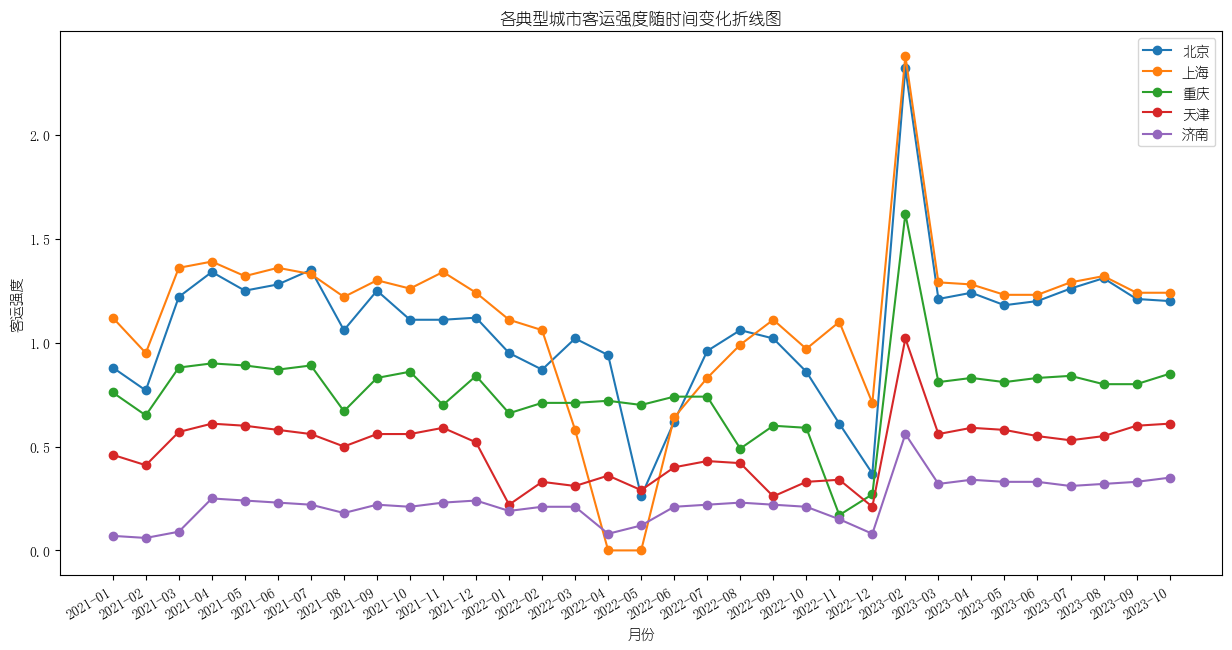

In [9]:
#各典型城市客运强度随时间变化

def plot_city_data(data, city_list, value_column, x_column="时间", y_label="", title=""):
    """
    参数：
    - data: 包含城市数据的 DataFrame
    - city_list: 要绘制的城市列表
    - value_column: 数据中表示值的列名
    - x_column: 数据中表示 x 轴的列名，默认为 "时间"
    - y_label: y 轴的标签
    - title: 图表标题
    """
    city_example = data[data["城市"].isin(city_list)]
    pivot_table = city_example.pivot_table(index=x_column, columns="城市", values=value_column)

    plt.figure(figsize=(15, 8))

    for city in city_list:
        plt.plot(pivot_table.index, pivot_table[city], label=city, marker='o')

    plt.xlabel('月份')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

# 使用函数绘制图表
city_list1 = ["北京", "上海", "重庆", "天津", "济南"]
plot_city_data(total_data, city_list1, value_column="客运强度（万人次每公里日）", y_label="客运强度", title='各典型城市客运强度随时间变化折线图')

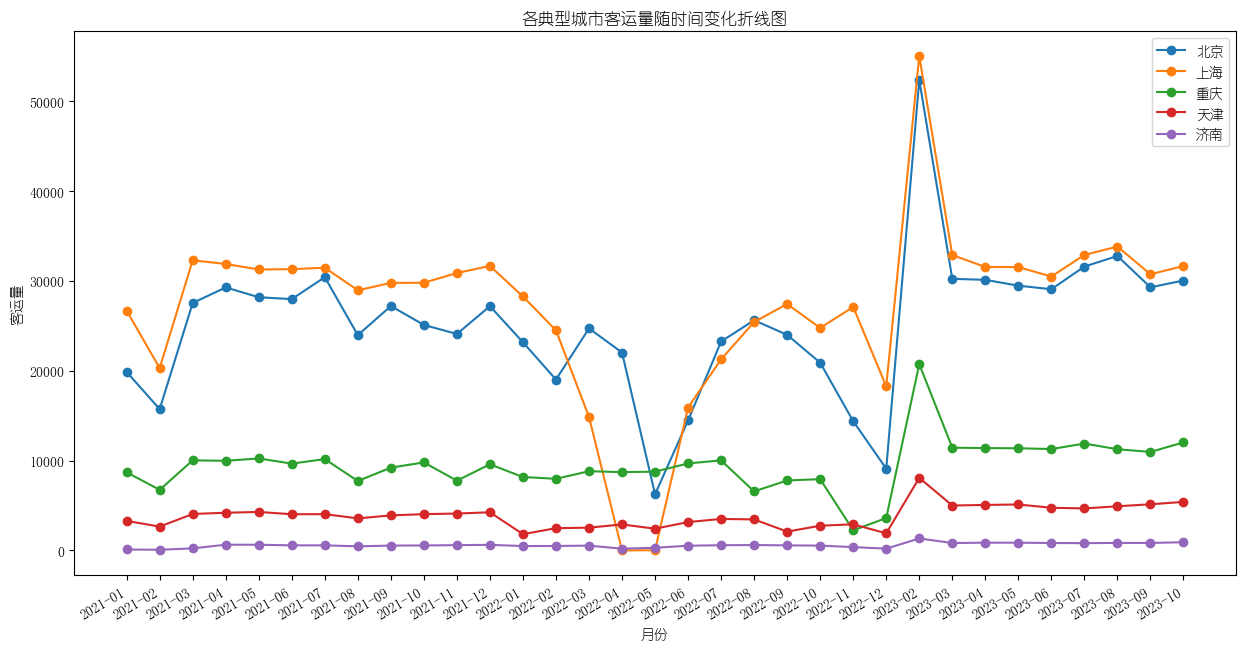

In [10]:
#各典型城市客运量随时间变化

plot_city_data(total_data, city_list1, value_column="客运量（万人次）", y_label="客运量", title='各典型城市客运量随时间变化折线图')